# **CONTENT-BASED COLLABORATIVE RECOMMENDER SYSTEM**

Import library yang di butuhkan

In [ ]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import re

# **Data loading**

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
! kaggle datasets download -d CooperUnion/anime-recommendations-database

100% 25.0M/25.0M [00:03<00:00, 16.3MB/s]
100% 25.0M/25.0M [00:03<00:00, 8.36MB/s]


In [ ]:
! unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


Import dataset

In [ ]:
anime_df = pd.read_csv('anime.csv')
rating_df = pd.read_csv('rating.csv')

# **Data Understanding**
**Variabel-variabel pada dataset adalah sebagai berikut:**
**anime.csv**
- anime_id : id unik anime
- name : nama anime
- genre : genre anime
- type : tipe siaran anime (TV, Movie, etc)
- episodes : jumlah episode anime
- rating : rating anime
- members : total user

**rating.csv**
- user_id : id unik user
- anime_id : id unik anime
- rating : rating yang diberikan oleh user


In [ ]:
anime_df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


# **Memeriksa informasi pada table anime**

In [ ]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


informasi dataframe anime.csv

# **Menghilangkan missing value**

In [ ]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [ ]:
anime_df =  anime_df.dropna()
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Jika dilihat dari data anime di atas. Terdapat sejumlah kolom missing value pada data anime.csv.

**Membersihkan simbol-simbol**

In [ ]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    
    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Membersihkan karakter yang tidak bisa di baca, kemungkinan adanya huruf jepang

In [ ]:
anime_df['genre'] = pd.DataFrame(anime_df['genre'].str.replace('|', ',', regex=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# **Visualization**

In [ ]:
genre_data = (anime_df.set_index(anime_df.columns.drop('genre',1).tolist())['genre']
               .str.split(',', expand=True)
               .stack()
               .reset_index()
               .rename(columns={0:'genre'})
               .loc[:, anime_df.columns]
               )

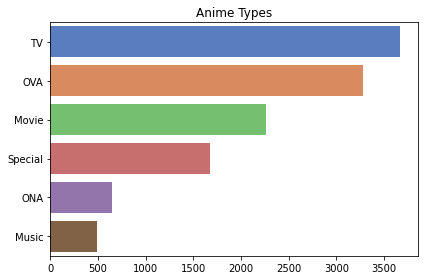

In [ ]:
type_count = anime_df['type'].value_counts()

sns.barplot(x=type_count.values,
            y=type_count.index,
            palette='muted').set_title('Anime Types')

plt.tight_layout()
plt.show()

Anime bertipe TV mampunyai jumlah paling banyak 

# **Memeriksa informasi dari data table rating**

In [ ]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Informasi Dataframe rating.csv


In [ ]:
rating_df = rating_df.drop(range(2000, 7813737))
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
1995,17,20931,5
1996,17,20939,-1
1997,17,20965,6
1998,17,20973,6


**Menghilangkan nilai -1 pada kolom rating**

In [ ]:
rating_df["rating"].replace({-1: np.nan}, inplace=True)
rating_df.head()

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN


**Menghapus kolom pertama pada table rating**

In [ ]:
rating_df = rating_df.dropna(axis = 0, how ='any')
rating_df

,user_id,anime_id,rating
47,1,8074,10.0
81,1,11617,10.0
83,1,11757,10.0
101,1,15451,10.0
153,2,11771,10.0
...,...,...,...
1993,17,20899,9.0
1994,17,20903,6.0
1995,17,20931,5.0
1997,17,20965,6.0


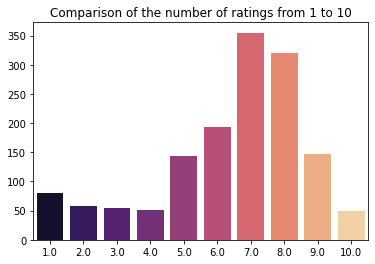

In [ ]:
rating_count = rating_df['rating'].value_counts().sort_index()

sns.barplot(x=rating_count.index,
            y=rating_count.values,
            palette='magma').set_title('Comparison of the number of ratings from 1 to 10');

Rating 7 paling banyak diberikan pada dataset ini

### **Content Based** 

**Data Preparation**


In [ ]:
tf = TfidfVectorizer()
tf.fit(anime_df['genre']) 
tf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

Tfid Vectorizer

In [ ]:
tfidf_matrix = tf.fit_transform(anime_df['genre']) 

tfidf_matrix.shape

(12017, 47)

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=anime_df.name
).sample(22, axis=1).sample(10, axis=0)

,magic,of,comedy,martial,parody,psychological,yaoi,super,fantasy,kids,...,action,adventure,music,cars,game,yuri,hentai,mystery,mecha,slice
name,,,,,,,,,,,,,,,,,,,,,
Zou no Senaka: Tabidatsu Hi,0.0,0.435290,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.435290
Battle Spirits Shinnen Special,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.463544,...,0.379178,0.000000,0.0,0.0,0.800844,0.0,0.0,0.0,0.0,0.000000
Gattai Robot Atranger,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.000000
Nat-chan no Akai Tebukuro,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.630845,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Blood-C: None-None Gekijou,0.0,0.000000,0.408436,0.0,0.912787,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Esper Mami Special: My Angel Mami-chan,0.0,0.000000,0.270890,0.0,0.000000,0.0,0.0,0.589922,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Ukkari Pénélope OVA,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
Cooking Papa Christmas Special,0.0,0.545968,0.325202,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.545968
Seishoujo Kantai Virgin Fleet,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.369191,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


**Cosine Similarity**

mencari kemiripan antar item

# **Transformasi data kedalam bentuk matriks**


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_df['name'], columns=anime_df['name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12017, 12017)


name,Sore Ike! Anpanman: Kuruyuki-hime to Mote Mote Baikinman,Strange Dawn,Baku Tech! Bakugan,Shiroi Michi,Mama Puri!?
name,,,,,
Taiho Shichau zo in America,0.128752,0.000000,0.339198,0.000000,0.00000
Saiyuuki Reload,0.357161,0.681734,0.136732,0.000000,0.00000
One: Kagayaku Kisetsu e - True Stories,0.000000,0.000000,0.000000,0.000000,1.00000
Monster Strike: Mermaid Rhapsody,0.251420,0.240337,0.808630,0.000000,0.00000
Reijou Caster: Ingyaku no Wana,0.000000,0.000000,0.000000,0.000000,1.00000
Yakusoku,0.000000,0.000000,0.000000,0.000000,0.00000
Souta no Chikai: Sabetsu ni Makenai Chikara,0.365840,0.302141,0.000000,0.000000,0.00000
Airy Me,0.000000,0.206706,0.000000,0.451296,0.00000
Boku no Pico,0.000000,0.000000,0.000000,0.000000,0.44672


**Membuat fungsi rekomendasi** 

In [ ]:
def anime_recommendation(nama_anime, similarity_data=cosine_sim_df, items=anime_df[['name', 'genre']], k=5):
    
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(
        range(-1, -k, -1))
    
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    closest = closest.drop(nama_anime, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

Test rekomendasi

In [ ]:
anime_df[anime_df.name.eq('One Piece')]

,anime_id,name,genre,type,episodes,rating,members
74,21,One Piece,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",TV,Unknown,8.58,504862


In [ ]:
anime_recommendation('One Piece')

,name,genre
0,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
1,One Piece: Episode of Nami - Koukaishi no Nami...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
2,One Piece: Episode of Merry - Mou Hitori no Na...,"Action, Adventure, Comedy, Drama, Fantasy, Sho..."
3,One Piece: Oounabara ni Hirake! Dekkai Dekkai ...,"Action, Adventure, Comedy, Fantasy, Shounen, S..."
4,One Piece: Adventure of Nebulandia,"Action, Adventure, Comedy, Fantasy, Shounen, S..."


In [ ]:
anime_recommendation('AD Police')

,name,genre
0,Death Note,"Mystery, Police, Psychological, Supernatural, ..."
1,Death Note Rewrite,"Mystery, Police, Psychological, Supernatural, ..."
2,Mousou Dairinin,"Drama, Mystery, Police, Psychological, Superna..."
3,Ghost in the Shell: Arise - Border:2 Ghost Whi...,"Mecha, Police, Psychological, Sci-Fi"
4,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"


### **COLLABORATIVE**

In [ ]:
rating_df

,user_id,anime_id,rating
47,1,8074,10.0
81,1,11617,10.0
83,1,11757,10.0
101,1,15451,10.0
153,2,11771,10.0
...,...,...,...
1993,17,20899,9.0
1994,17,20903,6.0
1995,17,20931,5.0
1997,17,20965,6.0


memanggil dataset rating.csv

**Data encoding**

In [ ]:
user_ids = rating_df['user_id'].unique().tolist()
print('list user_id: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded value to user_id: ', user_encoded_to_user)

list user_id:  [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]
encoded user_id :  {1: 0, 2: 1, 3: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 14: 10, 15: 11, 16: 12, 17: 13}
encoded value to user_id:  {0: 1, 1: 2, 2: 3, 3: 5, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 14, 11: 15, 12: 16, 13: 17}


**Memisahkan user_id dan anime_id**

In [ ]:
anime_ids = rating_df['anime_id'].unique().tolist()

anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}

anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

In [ ]:
rating_df['user'] = rating_df['user_id'].map(user_to_user_encoded)

rating_df['anime'] = rating_df['anime_id'].map(anime_to_anime_encoded)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)

num_anime = len(anime_encoded_to_anime)
print(num_anime)

min_rating = min(rating_df['rating'])

max_rating = max(rating_df['rating'])
 
print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

14
966
Number of User: 14, Number of Anime: 966, Min Rating: 1.0, Max Rating: 10.0


In [ ]:
rating_df = rating_df.sample(frac=1, random_state=42)
rating_df

,user_id,anime_id,rating,user,anime
1293,12,2904,10.0,9,549
1555,14,11887,8.0,10,831
1254,11,6707,4.0,8,774
1796,17,10396,5.0,13,310
739,5,25157,1.0,3,490
...,...,...,...,...,...
1526,14,8676,7.0,10,819
1561,14,14345,7.0,10,53
1759,17,8100,7.0,13,904
1110,7,30365,7.0,4,677


mengacak urutan data

**Train n Split**

In [ ]:
x = rating_df[['user', 'anime']].values

y = rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * rating_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  9 549]
 [ 10 831]
 [  8 774]
 ...
 [ 13 904]
 [  4 677]
 [ 10 350]] [1.         0.77777778 0.33333333 ... 0.66666667 0.66666667 0.66666667]


Membuat Fungsi rekomendasi

In [ ]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])
 
    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2) 
 
    x = dot_user_anime + user_bias + anime_bias
    
    return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_anime, 50)
 
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

**Train model**

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
146/146 [==============================] - 4s 6ms/step - loss: 0.6944 - root_mean_squared_error: 0.2681 - val_loss: 0.6721 - val_root_mean_squared_error: 0.2540
Epoch 2/20
146/146 [==============================] - 1s 4ms/step - loss: 0.6747 - root_mean_squared_error: 0.2488 - val_loss: 0.6668 - val_root_mean_squared_error: 0.2488
Epoch 3/20
146/146 [==============================] - 1s 5ms/step - loss: 0.6620 - root_mean_squared_error: 0.2364 - val_loss: 0.6572 - val_root_mean_squared_error: 0.2391
Epoch 4/20
146/146 [==============================] - 1s 4ms/step - loss: 0.6564 - root_mean_squared_error: 0.2297 - val_loss: 0.6554 - val_root_mean_squared_error: 0.2373
Epoch 5/20
146/146 [==============================] - 1s 5ms/step - loss: 0.6560 - root_mean_squared_error: 0.2307 - val_loss: 0.6493 - val_root_mean_squared_error: 0.2309
Epoch 6/20
146/146 [==============================] - 1s 5ms/step - loss: 0.6466 - root_mean_squared_error: 0.2192 - val_loss: 0.6469 - val_

Visualisasi train dan test

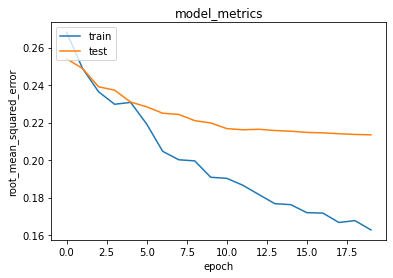

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Membuat fungsi rekomendasi

In [ ]:
anime_df = anime_df
ratingh_df = rating_df

userID = rating_df.user_id.sample(1).iloc[0]
anime_watched_by_user = rating_df[rating_df.user_id == userID]
 
anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id'] 
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)
 
anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(userID)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

Menggabungkan hasil dari content based dan collaborative

In [ ]:
ratings = model.predict(user_anime_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(userID))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)
 
top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)
 
anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)
 
print('----' * 8)
print('Top 10 anime recommendation')
print('----' * 8)
 
recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(row.name, ':', row.genre)

20/20 [==============================] - 0s 2ms/step
Showing recommendations for users: 7
Anime with high ratings from user
--------------------------------
No Game No Life : Adventure, Comedy, Ecchi, Fantasy, Game, Supernatural
Neon Genesis Evangelion : Action, Dementia, Drama, Mecha, Psychological, Sci-Fi
Pokemon: The Origin : Action, Adventure, Comedy, Fantasy, Kids
Umineko no Naku Koro ni : Horror, Mystery, Psychological, Supernatural
Hayate no Gotoku! Cant Take My Eyes Off You : Comedy, Harem, Parody, Shounen
--------------------------------
Top 10 anime recommendation
--------------------------------
Haikyuu!! Second Season : Comedy, Drama, School, Shounen, Sports
Sen to Chihiro no Kamikakushi : Adventure, Drama, Supernatural
Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai. : Drama, Slice of Life, Supernatural
Magi: The Kingdom of Magic : Action, Adventure, Fantasy, Magic, Shounen
Sakamichi no Apollon : Drama, Josei, Music, Romance, School
Fate/stay night: Unlimited Blade